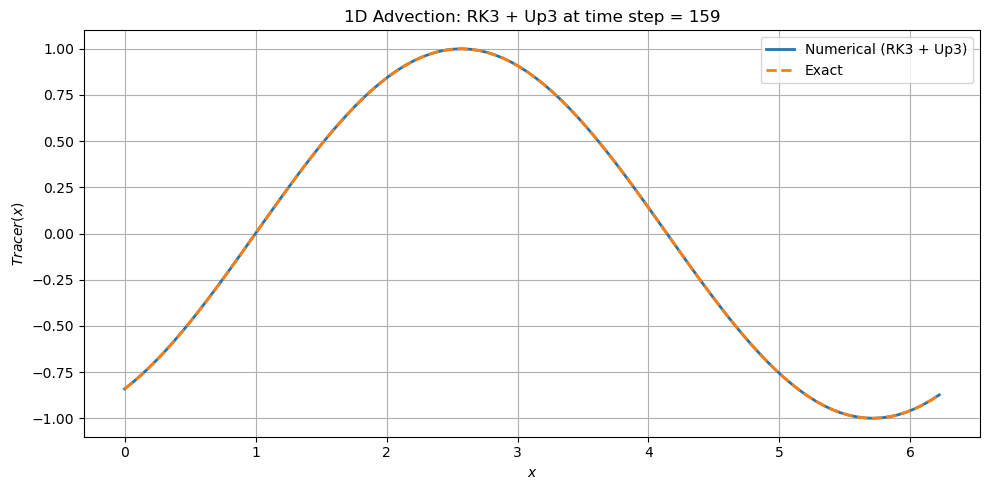

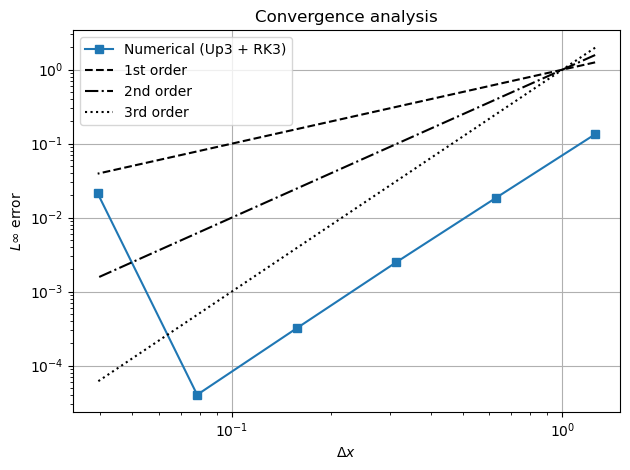

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
L = 2 * np.pi
time_final = 1
u = 1.0                 # Constant velocity
CFL = 0.1

# --- Initial condition ---
def initial_condition(x):
    return np.sin(x)

# --- Up3 flux computation ---
def compute_flux_up3(T, u, dx):
    # Periodic padding for stencil
    T_padded = np.pad(T, (2,2), mode='wrap')
    flux = np.zeros(len(T)+1)  # N+1 interfaces
    # Compute at interfaces i+1/2 (for FV method)
    for i in range(len(flux)):
        ip = i + 2
        if u > 0:
            T_half = (2*T_padded[ip-1] + 5*T_padded[ip] - T_padded[ip+1]) / 6.
        else:
            T_half = (2*T_padded[ip+2] + 5*T_padded[ip+1] - T_padded[ip]) / 6.
        flux[i] = u * T_half
    return flux

# --- RK3 time stepping ---
def rk3_step(T, u, dx, dt):
    F1 = compute_flux_up3(T, u, dx)
    R1 = - (F1[1:] - F1[:-1]) / dx
    T1 = T + dt * R1

    F2 = compute_flux_up3(T1, u, dx)
    R2 = - (F2[1:] - F2[:-1]) / dx
    T2 = 0.75 * T + 0.25 * (T1 + dt * R2)

    F3 = compute_flux_up3(T2, u, dx)
    R3 = - (F3[1:] - F3[:-1]) / dx
    T = (1/3) * T + (2/3) * (T2 + dt * R3)
    
    return T

# --- Solver and convergence ---
def run_simulation(nx):
    dx = L / nx
    dt = CFL * dx / u
    nt = int(time_final // dt)

    DOM = np.linspace(0, L, nx, endpoint=False)               # periodic B.C.
    SOL_init = initial_condition(DOM)
    SOL_num = SOL_init.copy()

    for _ in range(nt):
        SOL_num = rk3_step(SOL_num, u, dx, dt)

    # Correct exact solution (shifted initial condition)
    SOL_exact = initial_condition((DOM - u * nt * dt) % L)
    return DOM, SOL_num, SOL_exact, dx, dt, nt


# --- Plot single resolution ---
DOM, SOL_num, SOL_exact, dx, dt, nt = run_simulation(100)
plt.figure(figsize=(10, 5))
plt.plot(DOM, SOL_num, label='Numerical (RK3 + Up3)', lw=2)
plt.plot(DOM, SOL_exact, '--', label='Exact', lw=2)
plt.xlabel('$x$')
plt.ylabel('$Tracer(x)$')
plt.title(f'1D Advection: RK3 + Up3 at time step = {nt}')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

ERROR = []
DX = []
DT = []
for nx in [5, 10, 20, 40, 80, 160]:
    dx = L / nx
    dt = CFL * dx / u
    DOM, SOL_num, SOL_exact, dx, dt, nt = run_simulation(nx)
    error = np.linalg.norm(SOL_num - SOL_exact, np.inf)
    ERROR.append(error)
    DX.append(dx)
    DT.append(DT)

DX = np.array(DX)

plt.loglog(DX, ERROR, 's-', label='Numerical (Up3 + RK3)')
plt.loglog(DX, DX**1, 'k--', label='1st order')
plt.loglog(DX, DX**2, 'k-.', label='2nd order')
plt.loglog(DX, DX**3, 'k:', label='3rd order')
plt.title(f'Convergence analysis')
plt.xlabel('$\Delta x$')
plt.ylabel('$L \infty$ error')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()